### Import census data

In [1]:
import pandas as pd
import geopandas as gpd
from census import Census
from us import states
import requests
import geojson
import matplotlib.pyplot as plt

In [ ]:
# Set API key
c = Census("YOUR_API_KEY_HERE") # get it here: https://api.census.gov/data/key_signup.html

In [3]:
# Obtain Census variables from the 2020 ACS at the tract level for New York
# and counties: "005", "047", "061", "081", "085"

# C17002_001E: count of ratio of income to poverty in the past 12 months (total)
# C17002_002E: count of ratio of income to poverty in the past 12 months (< 0.50)
# C17002_003E: count of ratio of income to poverty in the past 12 months (0.50 - 0.99)
# B01003_001E: total population

# Sources: https://api.census.gov/data/2020/acs/acs5/variables.html; https://pypi.org/project/census/

# List of desired county FIPS codes as strings
county_fips_list = ["005", "047", "061", "081", "085"] # corresponding NY counties: Bronx, Queens, Kings, Richmond, New York

ny_census = c.acs5.state_county_tract(fields = ('NAME', 'B01003_001E'),
                                      state_fips = states.NY.fips,
                                      county_fips=",".join(county_fips_list),
                                      tract = "*",
                                      year = 2020)


In [4]:
ny_census[0:2]

[{'NAME': 'Census Tract 92.02, Kings County, New York',
  'B01003_001E': 3453.0,
  'state': '36',
  'county': '047',
  'tract': '009202'},
 {'NAME': 'Census Tract 94.01, Kings County, New York',
  'B01003_001E': 2293.0,
  'state': '36',
  'county': '047',
  'tract': '009401'}]

In [5]:
# Create a dataframe from census data
ny_df = pd.DataFrame(ny_census)

# Rename column 'B01003_001E' to 'population'
ny_df = ny_df.rename(columns={'B01003_001E': 'population', 'NAME':'name'})

print(ny_df.head(2))
print('Shape: ', ny_df.shape)

                                         name  population state county   tract
0  Census Tract 92.02, Kings County, New York      3453.0    36    047  009202
1  Census Tract 94.01, Kings County, New York      2293.0    36    047  009401
Shape:  (2327, 5)


### Get GEOID by combining state & county Fips codes + tract no.

In [6]:
# Combine state, county, and tract columns together to create a new string and assign to new column
ny_df["GEOID"] = ny_df["state"] + ny_df["county"] + ny_df["tract"]

In [7]:
ny_df.head(2)

,name,population,state,county,tract,GEOID
0,"Census Tract 92.02, Kings County, New York",3453.0,36,047,009202,36047009202
1,"Census Tract 94.01, Kings County, New York",2293.0,36,047,009401,36047009401


### Import tracts geojson to geodataframe

In [8]:
url = "https://services5.arcgis.com/GfwWNkhOj9bNBqoJ/arcgis/rest/services/NYC_Census_Tracts_for_2020_US_Census/FeatureServer/0/query?where=1=1&outFields=*&outSR=4326&f=geojson"

response = requests.get(url)

if response.status_code == 200:
    # Load GeoJSON data and specify CRS
    ny_tract = gpd.GeoDataFrame.from_features(geojson.loads(response.text), crs='EPSG:4326')

    # Select the desired columns
    ny_tract = ny_tract[['GEOID', 'geometry']]

    # Reproject to local CRS 2263
    ny_tract = ny_tract.to_crs(epsg=2263)

    print(ny_tract.head(2))
    print('Shape: ', ny_tract.shape)

    print("\nThe shapefile projection is: {}".format(ny_tract.crs))

         GEOID                                           geometry
0  36061000100  MULTIPOLYGON (((972081.369 190736.621, 972184....
1  36061000201  POLYGON ((988547.752 197773.594, 987978.309 19...
Shape:  (2325, 2)

The shapefile projection is: EPSG:2263


### Check column data types of the two dataframes [ny_df & ny_tract]

In [9]:
# Check column data types for census dataframe & tract geodataframe
print("Column data types for census data:\n{}".format(ny_df.dtypes))
print("\nColumn data types for tract geodataframe:\n{}".format(ny_tract.dtypes))

Column data types for census data:
name           object
population    float64
state          object
county         object
tract          object
GEOID          object
dtype: object

Column data types for tract geodataframe:
GEOID         object
geometry    geometry
dtype: object


### Merge ny_df & ny_tract data

In [10]:
ny_merge = ny_tract.merge(ny_df, on = "GEOID")

# Show result
print(ny_merge.head(2))
print('Shape: ', ny_merge.shape)

         GEOID                                           geometry  \
0  36061000100  MULTIPOLYGON (((972081.369 190736.621, 972184....   
1  36061000201  POLYGON ((988547.752 197773.594, 987978.309 19...   

                                           name  population state county  \
0     Census Tract 1, New York County, New York         0.0    36    061   
1  Census Tract 2.01, New York County, New York      2761.0    36    061   

    tract  
0  000100  
1  000201  
Shape:  (2325, 7)


<Axes: >

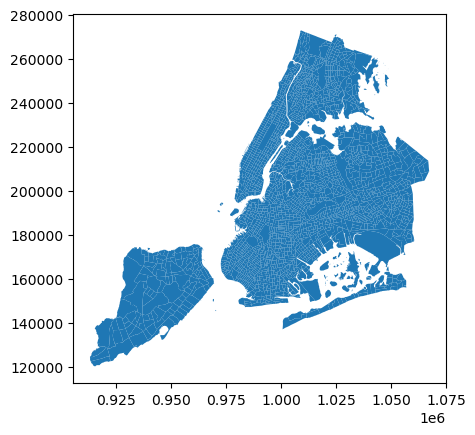

In [11]:
ny_merge.plot()

### Store geodataframe in memory

In [12]:
%store ny_merge

Stored 'ny_merge' (GeoDataFrame)
